# Manchu Script Reader

### An Efficient Method to Extract Units of Manchu Characters

1. Aaron Daniel Snowberger [aaron.snowberger@gmail.com](mailto:aaron.snowberger@gmail.com)
2. Choong Ho Lee [chlee@hanbat.ac.kr](mailto:chlee@hanbat.ac.kr)

#### Abstract

Since Manchu characters are written vertically and are connected without spaces within a word, a preprocessing
process is required to separate the character area and the units that make up the characters before recognizing the
characters. In this paper, we describe a preprocessing method that extracts the character area and cuts off the unit of the character. Unlike existing research that presupposes a method of recognizing each word or character unit, or recognizing the remaining part after removing the stem of a continuous character, this method cuts the character into each recognizable unit and then combines the units. It can be applied to the method of recognizing letters. Through an experiment, the effectiveness of this method was verified.

##### Keywords

[Manchu Characters](https://en.wikipedia.org/wiki/Manchu_alphabet), Character Recognition, Preprocessing, Pattern Recognition

---
# 1. Load data

In [166]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

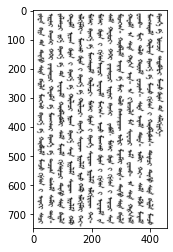

Image shape:  (748, 459)


In [167]:
# Manchurian script image source
scriptSrc = cv2.imread('./img/manchu01.jpg', cv2.IMREAD_GRAYSCALE)

# Visualize the image
plt.imshow(scriptSrc, cmap = plt.get_cmap('gray'))
plt.show()

# And check out its dimensions
height, width = scriptSrc.shape
print("Image shape: ", scriptSrc.shape)

---
# 2. Pre-process data

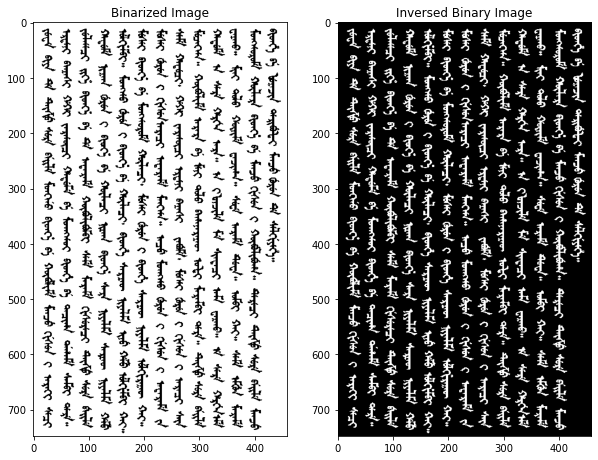

In [168]:
# Create binary image (only 1s and 0s) using threshold
ret, bin = cv2.threshold(scriptSrc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# inverse binary image (black bg, white txt)
ibin = cv2.bitwise_not(bin)

# Visualize both images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.set_title('Binarized Image')
ax1.imshow(bin, cmap = plt.get_cmap('gray'))
ax2.set_title('Inversed Binary Image')
ax2.imshow(ibin, cmap = plt.get_cmap('gray'))
plt.show()

## 2.1 Find Lines
---

In the binary image, the white background pixel value is 1, and all pixels that contain the script are 0. Therefore, by inversing the binary image (reversing the 1s and 0s), we can easily scan the image looking for any location that contains the script data (1s). 

**Method:**

1. Create an array of 0s to represent the entire width of the image (459px).
2. Traverse every column of the binary image (`ibin[:,col]`) and scan the column for data (1s)
3. Store the number of pixels that contain data in our array for every column.

Next, to determine the number of lines in the script, we compare every value in our columns array with the value that follows it (`i` and `i+`). If `i` contains data, but `i+1` does not, then we know that this is where one line of the script ends and the whitespace preceding the next line of the script begins. We can easily sum up the total number of lines of the script in this way (although this does not yet produce the optimal cutting lines).

Image width =  459

Before scanning:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

After scanning:
 [  0   0   0

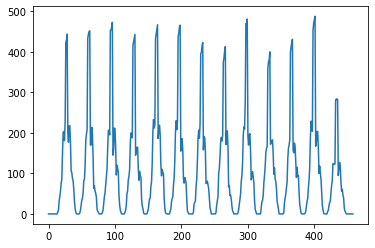

In [169]:
# Create an array of 0s to represent the entire width of the image (459px)
cols = np.full(width, 0)
print('Image width = ', len(cols))
print('\nBefore scanning:\n', cols)

# For every col, find anything with data (a pixel of the script)
for i in range(width):
    cols[i] = cv2.countNonZero(ibin[:, i])
print('\nAfter scanning:\n', cols)

# Var to hold num of font areas (vertical lines of text) based on the script
n_fontarea = 0

# Determine font areas by checking where a non-zero col ends and a zero col begins
for i in range(width - 1):
    if cols[i] > 0 and cols[i+1] == 0:  # here, our script ends, and whitespace begins
        n_fontarea = n_fontarea + 1  # so, it's the end of a n_fontarea (+1)

# Tell me how many font areas there are (i.e. how many vertical lines of text)
print("\nNumber of font areas = ", n_fontarea)

# We can also visualize this data in a matplotlib graph
plt.plot(cols)
plt.show()

### Simplify column data by binarization

This simply means that if there is any kind of data in the column, set its value to 1. But if there is no data, its value remains 0. Basically, it looks a bit like the following function:

\begin{equation*}
\:f(x) = \begin{cases}
    1 & \text{if } x > 0, \\
    0 & \text{otherwise}
\end{cases} 
\end{equation*}

In [170]:
# Make a copy of the cols to manipulate it
bcols = cols.copy()

# Kind of like using ReLU (Rectified Linear Unit) to return either a 1 if data exists, otherwise it remains 0
for i in range(width):
    if cols[i] > 0:  # if some data exists in this col
        bcols[i] = 1  # then set bcols at the same location to 1 (binary)
print('Original column data:\n', cols)
print('\nBinarized column data:\n', bcols)

Original column data:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   5  10  33  43
  57  76  86 150 202 203 181 228 424 429 444 201 177 217 218 177 106 102
  88  81  60  31  13   5   0   0   0   0   0   2   9  20  34  39  51  82
  85 117 181 197 207 433 444 450 452 170 170 214 199 143  63  69  56  51
  41  12   6   4   0   0   0   0   0   4   9  27  42  52  72  90 111 163
 206 207 195 453 454 461 473 145 162 212 210 163  96 120 113 102  45  22
   9   4   0   0   0   0   0   4   9  21  50  57  84  93 110 172 200 192
 188 416 425 435 443 145 160 164 165 113  83 105  94  91  38  20  13   3
   0   0   0   0   0   5  11  24  37  39  68  79 124 202 233 212 221 433
 445 459 467 186 211 219 196 120  94 110 103  98  39  14   3   1   0   0
   0   0   0   6  12  29  38  42  72  88 133 203 230 208 230 439 446 462
 466 155 184 186 158  88  76  90  84  76  34   7   4   0   0   0   0   0
   0   0   4  24  28  32  68  87 131 188 207 187 221 395 399 415 423 158
 191 188 157  75  77  81  71

### Find X cut points

Next, we create another array to store the X cut point locations. This array needs to be one value greater than the number of lines of the script so that we can cut *around* each line and get rid of any image column without script data (all 0s).

There will be 3 cases to resolve when traversing our columns array and determining X cut points:

1. End of the image (array)
2. When whitespace ends and a new line of the script begins (moving from 0 to 1)
3. When the line of script ends and whitespace begins (moving from 1 to 0)

In [340]:
# Define a function to find cutPoints for any given array.
# (This can be used for both horizontal and vertical cutPoints)
def findCutPoints(barr, debug = 0):
    """Find the points to cut the image.
    
    Args:
        barr: A binary array (1s and 0s) equivalent to the side of the image in question.
        debug: int value, whether or not to print all the output.
    
    """
    cutPoints = []

    # Initialize variables
    startpoint = 0  # start at the beginning of the image (col 0)
    endpoint = 0
    hasPair = 0
    lastItem = len(barr)

    # Loop to determine and set our cutXpoints (where to cut the image for each column of text)
    for i in range(0, len(barr) - 1):

        if endpoint == 1:
            cutPoints.append([startpoint, i])
            endpoint = 0
            hasPair = 1
            if debug == 1:
                print('cutPoint end: ', i)
        if barr[i] == 0 and barr[i+1] == 1: # This is the START of a script line
            startpoint = i
            hasPair = 0
            if debug == 1:
                print('\ncutPoint start: ', i)
        if barr[i] == 1 and barr[i+1] == 0: # This is the END of a script line
            endpoint = 1
    
    # Edge case found mostly in letters where the last endpoint sometimes is not found.
    if startpoint > endpoint and hasPair == 0:
        cutPoints.append([startpoint, len(barr)])
        
    # Confirm our points
    if debug == 1:
        print("\ncutPoints = ", cutPoints)
        print("\nNum slices based on cutPoints = ", len(cutPoints))
    
    return cutPoints


cutPoint start:  13
cutPoint end:  42

cutPoint start:  46
cutPoint end:  76

cutPoint start:  80
cutPoint end:  110

cutPoint start:  114
cutPoint end:  144

cutPoint start:  148
cutPoint end:  178

cutPoint start:  182
cutPoint end:  211

cutPoint start:  217
cutPoint end:  245

cutPoint start:  251
cutPoint end:  279

cutPoint start:  284
cutPoint end:  313

cutPoint start:  319
cutPoint end:  347

cutPoint start:  353
cutPoint end:  381

cutPoint start:  385
cutPoint end:  415

cutPoint start:  419
cutPoint end:  448

cutPoints =  [[13, 42], [46, 76], [80, 110], [114, 144], [148, 178], [182, 211], [217, 245], [251, 279], [284, 313], [319, 347], [353, 381], [385, 415], [419, 448]]

Num slices based on cutPoints =  13


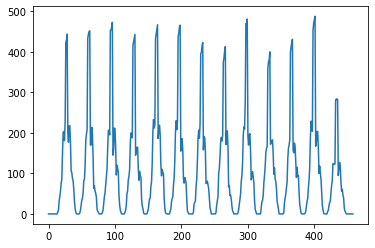

In [341]:
findCutPoints(bcols, 1)

# And take a look at the cutXpoints in a graph
plt.plot(cols)
plt.show()

Notice there are typically 4-6 pixels between each cutPoint end and the beginning of the next one. When we find the cut points like this, we can minimize the amount of whitespace in the cut portions of our image.

### Cut Lines

In [207]:
def cutAndSave(image, cutPoints, cutDirection, saveLocation):
    """Cut and Save.
    
    Args:
        image: The image to cut.
        cutPoints: An array of tuples [startPoint, endPoint] of cutpoints.
        cutDirection: int, 0 = horizontal cut line, 1 = vertical cut line.
        saveLocation: The folder in which to save the cut up images.
    """
    
    if image is not None:
        
        pieces = []
        height, width = image.shape
        
        # Now, using the cutPoints we determined, cut out and save
        for i in cutPoints:
            
            if cutDirection == 1: # vertical cuts, use the full height
                cutline = image[0:height, i[0]:i[1]]
                
            elif cutDirection == 0: # horizontal cuts, use the full width
                cutline = image[i[0]:i[1], 0:width]
                
            pieces.append(cutline)
            # print('writing img', i)
            filename = saveLocation + '/manchu01-' + str(i) + '.jpg'
            cv2.imwrite(filename, cutline)
            # print('finished img', i)
            
        print('Number of Pieces cut: ', len(pieces))
        
        return pieces

Number of Pieces cut:  13


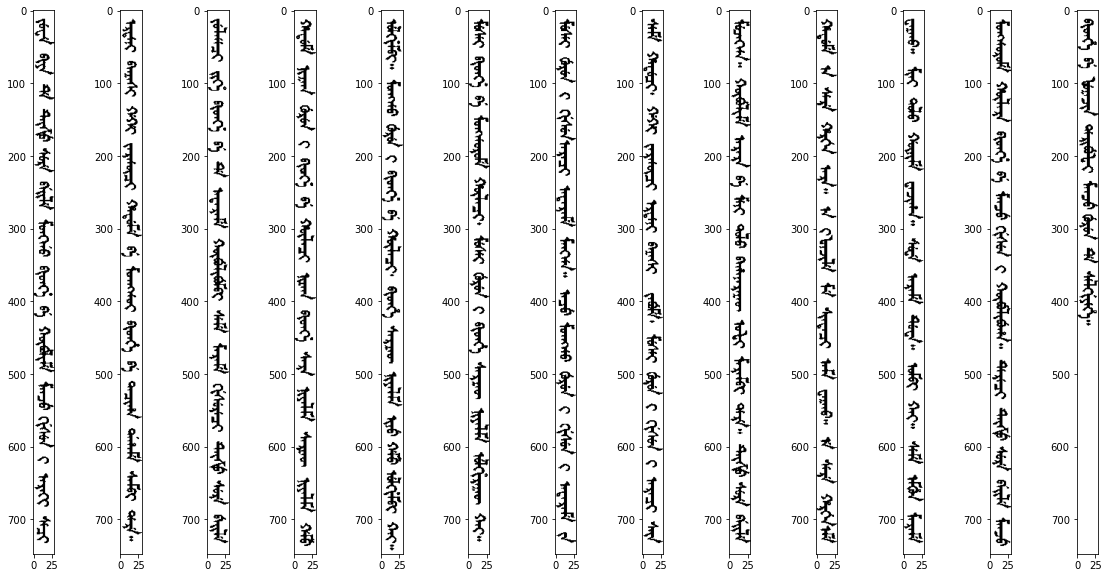

In [174]:
# Find cutPoints for our binary columns array that represents the width of the image
lineCutpts = findCutPoints(bcols)

# Actually cutAndSave pieces of our binary image based on the found cutPoints
lines = cutAndSave(bin, lineCutpts, 1, '/img/lines')

# Let's display our 13 columns of cut script
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13) = plt.subplots(1, 13, figsize = (20, 10))
ax1.imshow(lines[0], cmap = plt.get_cmap('gray'))
ax2.imshow(lines[1], cmap = plt.get_cmap('gray'))
ax3.imshow(lines[2], cmap = plt.get_cmap('gray'))
ax4.imshow(lines[3], cmap = plt.get_cmap('gray'))
ax5.imshow(lines[4], cmap = plt.get_cmap('gray'))
ax6.imshow(lines[5], cmap = plt.get_cmap('gray'))
ax7.imshow(lines[6], cmap = plt.get_cmap('gray'))
ax8.imshow(lines[7], cmap = plt.get_cmap('gray'))
ax9.imshow(lines[8], cmap = plt.get_cmap('gray'))
ax10.imshow(lines[9], cmap = plt.get_cmap('gray'))
ax11.imshow(lines[10], cmap = plt.get_cmap('gray'))
ax12.imshow(lines[11], cmap = plt.get_cmap('gray'))
ax13.imshow(lines[12], cmap = plt.get_cmap('gray'))

plt.show()

## 2.2 Find Words
---

We should now be able to find the words present in each line of script using the same two functions defined above:

1. `findCutPoints()`
2. `cutAndSave()`

However, there will be some slight modifications. 

- For cutting lines of script, we traversed the inverse binary image along its width, scanning for non-zero data in each column. Then, we found cut points wherever the whole column was all 0s and cut the lines there.
- For cutting words, we will need to traverse an inverse binary image along its height, scanning for non-zeros. We will then cut the words wherever the whole width is 0s.

So, actually, to help simplify things, let's create TWO new functions and chain them together with our previous functions to perform the tasks we need:

1. `preprocess(image, scanDirection, debug)` :
    1. Takes an image
    2. Creates a binary inverse of the image
2. `createBinArr(img, zeroArr, measure, scanDirection, debug)`
    1. Traverses the image in the direction we specify (width, height) counting non-zero values (script data), and storing those values in an array
    2. Performs our ReLU activation function on the array to make it contain only 1s and 0s (binary array)
3. `findCutPoints(barr, debug)` : 
4. `cutAndSave(image, cutPoints, cutDirection, saveLocation)` : 

### 1. Pre-process data

This function also utilizes a `createBinArr()` function that returns a binary array of values based on the scan direction (width or height) of the image.

In [257]:
def preprocess(image, scanDirection = 0, debug = 0, returnNonBinaryArray = 0):
    """Create a binary array for the width OR height of a given image (based on 
    scanDirection where 1 = height (scan every row), 0 = width (scan every column)).
    
    Args:
        image : The image to scan.
        scanDirection : Whether to scan vertically (1 = height, every row).
            or horizontally (0 = width, every column).
        debug : Whether or not to print array values (3 prints extra info).
        returnNonBinaryArray: Whether or not to return the non-binarized form of the array. Default = 0.
        
    Returns:
        Binary array that represents image cut points (data = 1, whitespace = 0).
        OR
        Array of values that represents the pixel depth at each location (returnNonBinaryArray == 1).
    """
    
    # Create binary version of the image.
    ret, bin_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Create binary inverse (white text on a black background).
    ibin_img = cv2.bitwise_not(bin_img)
    
    # Get the shape of the image so we know how far to scan.
    height, width = bin_img.shape
    
    # Check scanDirection
    ## Scan WIDTH (by column)
    if scanDirection == 0: # scan the width (by column)
        cols = np.full(width, 0)
        arr = createBinArr(ibin_img, cols, scanDirection, debug, returnNonBinaryArray)
        
    ## Scan HEIGHT (by row)
    elif scanDirection == 1: # scan the height (by row)
        rows = np.full(height, 0)
        arr = createBinArr(ibin_img, rows, scanDirection, debug, returnNonBinaryArray)
    
    return arr

### 2. Create a Binary Array

The results of this function are passed BACK to the `preprocess()` function to be used to determine the number of font areas present in the image.

In [265]:
def createBinArr(img, zeroArr, scanDirection, debug = 0, returnNonBinaryArray = 0):
    """Create a binary array (all 1s and 0s) from the given args.
    
    Args:
        img: The image we are scanning
        zeroArr: An array of all 0s that will be refilled with non-zero values after scanning.
        scanDirection: Passed from previous function: 1 = height, every row, 0 = width, every column.
        debug: Whether or not to print everything (if debug == 3, it prints a graph of the data).
        returnNonBinaryArray: Whether or not to return the non-binarized form of the array. Default = 0.
    
    Returns:
        Binary array that represents image cut points (data = 1, whitespace = 0).
        OR
        Array of values that represents the pixel depth at each location (returnNonBinaryArray == 1).
    """
    
    if debug == 1:
        print('Image array length = ', len(zeroArr))
        print('\nBefore scanning:\n', zeroArr)

    # For every col, find anything with data (a pixel of the script)
    for i in range(0, len(zeroArr)):
        if scanDirection == 0:
            zeroArr[i] = cv2.countNonZero(img[:,i])
        elif scanDirection == 1:
            zeroArr[i] = cv2.countNonZero(img[i,:])
    if debug == 1:
        print('\nAfter scanning:\n', zeroArr)
    if debug == 3:
        print('Plot of data points (0s indicate a cut line)')
        # And take a look at the cutXpoints in a graph
        plt.plot(zeroArr)
        plt.show()
        
    # In the case of finding letters, we want to return the non-binary array in order to
    # to a bit more pre-processing, like finding all the valleys (lowest values) in this array.
    if returnNonBinaryArray == 1:
        return zeroArr

    # Var to hold num of font areas (vertical lines of text) based on the script
    n_fontarea = 0

    # Determine font areas by checking where a non-zero col ends and a zero col begins
    for i in range(0, (len(zeroArr) - 1)):
        if zeroArr[i] > 0 and zeroArr[i+1] == 0:  # here, our script ends, and whitespace begins
            n_fontarea = n_fontarea + 1  # so, it's the end of a n_fontarea (+1)

    # Tell me how many font areas there are (i.e. how many vertical lines of text)
    print("Number of font areas = ", n_fontarea)   

    # Make a copy of the rows to manipulate it
    bin_arr = zeroArr.copy()

    # Kind of like using ReLU (Rectified Linear Unit) to return either a 1 if data exists, otherwise it remains 0
    for i in range(0, len(zeroArr)):
        if zeroArr[i] > 0:  # if some data exists in this row
            bin_arr[i] = 1  # then set brows at the same location to 1 (binary)
            
    # if debug == 3:
        # print(bin_arr)

    return bin_arr

### Visualize pre-processing

We also pass in a `debug` argument of 3 for the *first* line in order to visualize the data points present in the image and the binary array that is returned.


Lines of our image:

Line #1
Plot of data points (0s indicate a cut line)


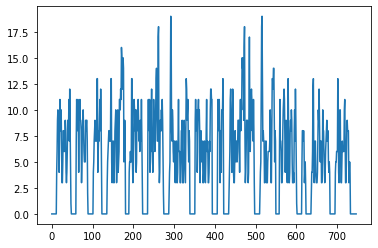

Number of font areas =  15

Line #2
Number of font areas =  14

Line #3
Number of font areas =  13

Line #4
Number of font areas =  14

Line #5
Number of font areas =  19

Line #6
Number of font areas =  15

Line #7
Number of font areas =  15

Line #8
Number of font areas =  16

Line #9
Number of font areas =  17

Line #10
Number of font areas =  18

Line #11
Number of font areas =  19

Line #12
Number of font areas =  15

Line #13
Number of font areas =  10


In [268]:
line_bin_arrs = []

print('\nLines of our image:')
for i, line in enumerate(lines):
    print('\nLine #' + str(i+1))
    if i == 0:
        line_bin_arrs.append(preprocess(line, 1, 3)) # 1 = scan height (rows)
    else:
        line_bin_arrs.append(preprocess(line, 1))

### 3. Find Y cut points

Next, we `findCutPoints()` for every line of the script (every item in `line_imgs`) along the vertical, Y-axis.

In [269]:
wordsCutPoints = []

# Now find the cutPoints for each word in the line
for line in line_bin_arrs:
    wordsCutPoints.append(findCutPoints(line))
    
pprint.pp(wordsCutPoints)

[[[11, 48],
  [59, 89],
  [101, 123],
  [135, 181],
  [189, 223],
  [235, 275],
  [287, 339],
  [351, 394],
  [406, 422],
  [434, 498],
  [510, 550],
  [558, 602],
  [613, 624],
  [636, 683],
  [695, 733]],
 [[11, 58],
  [69, 119],
  [131, 171],
  [182, 248],
  [259, 312],
  [324, 339],
  [351, 415],
  [426, 470],
  [482, 497],
  [509, 562],
  [574, 622],
  [633, 675],
  [686, 721],
  [722, 731]],
 [[11, 71],
  [83, 111],
  [124, 167],
  [180, 195],
  [207, 230],
  [243, 300],
  [313, 400],
  [412, 444],
  [457, 500],
  [513, 580],
  [592, 638],
  [646, 680],
  [693, 733]],
 [[12, 61],
  [75, 117],
  [130, 166],
  [179, 190],
  [203, 243],
  [256, 272],
  [285, 347],
  [360, 398],
  [412, 456],
  [469, 503],
  [517, 566],
  [579, 628],
  [642, 691],
  [704, 737]],
 [[11, 72],
  [73, 77],
  [73, 82],
  [95, 146],
  [156, 189],
  [199, 210],
  [220, 264],
  [274, 289],
  [300, 362],
  [300, 366],
  [379, 423],
  [433, 486],
  [496, 545],
  [556, 586],
  [593, 625],
  [632, 692],
  [703, 

### 4. Cut Words 

In [270]:
"""Remember all the pieces we need:

lines[] : an array of the previously cut and saved line IMAGES
wordsCutPoints[] : array of arrays of CUT POINTS for our images. 
    wordsCutPoints[0] is the first line, wordsCutPoints[0][i] is each cut point in that line

cutAndSave(image, cutPoints, cutDirection, saveLocation) : function to perform the cuts
    image: The image to cut.
    cutPoints: An array of tuples [startPoint, endPoint] of cutpoints.
    cutDirection: int, 0 = horizontal cut line, 1 = vertical cut line.
    saveLocation: The folder in which to save the cut up images.
"""

# Actually cutAndSave pieces of our binary image based on the found cutPoints
words = []

for i in range(0, len(lines)):        
    words.append(cutAndSave(lines[i], wordsCutPoints[i], 0, '/img/words'))

Number of Pieces cut:  15
Number of Pieces cut:  14
Number of Pieces cut:  13
Number of Pieces cut:  14
Number of Pieces cut:  19
Number of Pieces cut:  15
Number of Pieces cut:  15
Number of Pieces cut:  16
Number of Pieces cut:  17
Number of Pieces cut:  18
Number of Pieces cut:  19
Number of Pieces cut:  15
Number of Pieces cut:  10


<class 'numpy.ndarray'>
Number of words in line 1 = 15


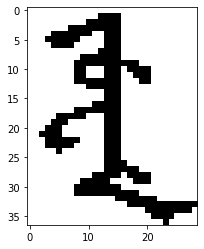

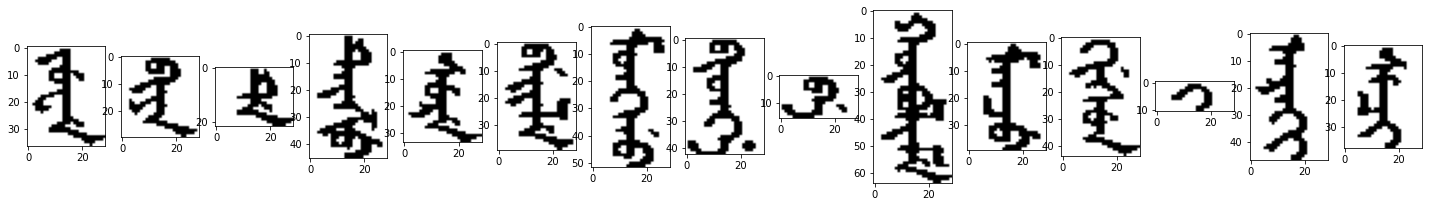

In [361]:
# print(words[0])
print(type(words[0][0]))
print('Number of words in line 1 =', (len(words[0])))
plt.imshow(words[0][0], cmap = plt.get_cmap('gray'))

# Now, let's double-check and display the 15 words cut from the first line of the script
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15) = plt.subplots(1, 15, figsize = (25, 10))
ax1.imshow(words[0][0], cmap = plt.get_cmap('gray'))
ax2.imshow(words[0][1], cmap = plt.get_cmap('gray'))
ax3.imshow(words[0][2], cmap = plt.get_cmap('gray'))
ax4.imshow(words[0][3], cmap = plt.get_cmap('gray'))
ax5.imshow(words[0][4], cmap = plt.get_cmap('gray'))
ax6.imshow(words[0][5], cmap = plt.get_cmap('gray'))
ax7.imshow(words[0][6], cmap = plt.get_cmap('gray'))
ax8.imshow(words[0][7], cmap = plt.get_cmap('gray'))
ax9.imshow(words[0][8], cmap = plt.get_cmap('gray'))
ax10.imshow(words[0][9], cmap = plt.get_cmap('gray'))
ax11.imshow(words[0][10], cmap = plt.get_cmap('gray'))
ax12.imshow(words[0][11], cmap = plt.get_cmap('gray'))
ax13.imshow(words[0][12], cmap = plt.get_cmap('gray'))
ax14.imshow(words[0][13], cmap = plt.get_cmap('gray'))
ax15.imshow(words[0][14], cmap = plt.get_cmap('gray'))

plt.show()

## 3. Find Letters
---

Now that we have an array of words, we should be able to find each letter in each word.

We will need to create at least one new function for this which will be another type of ReLU activation function. 

This time, when we create our binary array, we cannot depend on counting non-zero values in order to determine cut points. Rather, we will need to find all the "valleys," or the narrowest pixel width locations in each word (usually around 4-6 pixels wide).

#### Review

Very quickly, let's review all of the pieces we've built so far, and how the program runs.

**Functions**

1. `preprocess(image, scanDirection = 0, debug = 0)`
    1. Utilizes `createBinArr()` to create a binary array representing our image cut points.
    1. Args:
        1. `image` : The image to process.
        2. `scanDirection` : 1 = height (scan every row), 0 = width (scan every column), default = 0.
        3. `debug` : Whether or not to include `print()` statements for debugging (3 prints extra info), default = 0.
    2. Returns:
        1. Binary array that represents image cut points (data = 1, whitespace = 0).
2. `findCutPts(barr, debug = 0)`
    1. Args: 
        1. `barr` : The binary array we are using to find cutPts (it may include lots of concurrent 1s and 0s, and we want to cut at the 0s closest to the 1s).
        2. `debug` : Whether or not to include `print()` statements for debugging.
    2. Returns:
        1. Array of tuples [startpoint, endpoint] representing the cutPoints in the image.
3. `cutAndSave(image, cutPoints, cutDirection, saveLocation)`
    1. Args:
        1. `image` : The image to cut.
        2. `cutPoints` : An array of tuples [startpoint, endpoint] representing the cutPoints.
        3. `cutDirection` : 1 = vertical cuts, 0 = horizontal cuts.
        4. `saveLocation` : The folder in which to (theoretically) save the cut images.
    2. Returns:
        1. An array `<numpy.ndarray>` (floats) of the cut up images
    
**Variables**

1. `scriptSrc` : IMAGE Original source image.
1. `lines[]` : `<numpy.ndarray>` ARRAY of the lines cut from the `scriptSrc`
2. `words[]` : ARRAY of `<numpy.ndarray>` ARRAYS of the words cut from each line

### Pre-process and Visualize the first word

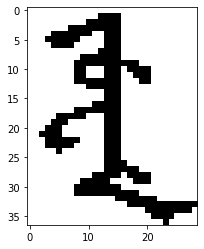

Image array length =  37

Before scanning:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

After scanning:
 [ 0  4  6  9 10  9  7  4  7 11  9  8 10  6  3  3  5  8  8  6  6  7  9  8
  4  3  4  6  9  8  8 11  7 12  8  4  1]
Number of font areas =  0

Plot of data points (0s indicate a cut line)


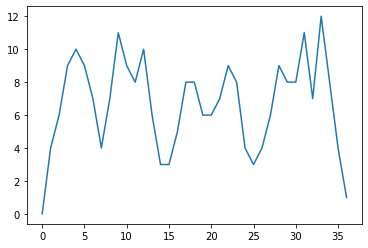

Number of font areas =  0


array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [275]:
# Pre-process and Visualize the first word
plt.imshow(words[0][0], cmap = plt.get_cmap('gray'))
plt.show()

preprocess(words[0][0], 1, 1) # display debugging information for the arrays
print()
preprocess(words[0][0], 1, 3) # display a graph of the array data

Here we can see that there should be 3 total cut points in the first word, creating 4 letters. On the plot, these cut points are located wherever the data value is 3 or 4 (the lowest points on the y-axis). These locations are at points 7, 14-15, and 25 on the x-axis.

### Find Valleys by adjusting the pre-processing return value

Because there are no zero values in a word, we can't use the binary array that our `preprocess()` function returns. Therefore, we need to return the non-binarized array early and do a bit more pre-processing on that array in order to find the valleys (the lowest pixel depth values).

We will create a new function for this called `findValleys` that takes in a non-binarized array, finds the valley points, zeroes them, and returns a new binarized array with valley cut points. We can then use this array with the rest of our functions in order to finish cutting all the letters from our words.

Plot of data points (0s indicate a cut line)


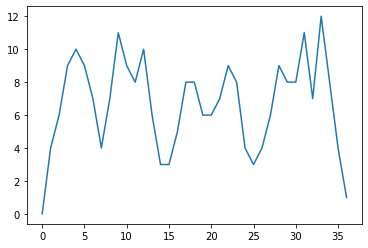


Before finding valleys:
 [ 0  4  6  9 10  9  7  4  7 11  9  8 10  6  3  3  5  8  8  6  6  7  9  8
  4  3  4  6  9  8  8 11  7 12  8  4  1]

After finding valleys:
 [ 0  4  6  9 10  9  7  0  7 11  9  8 10  6  3  0  5  8  8  6  6  7  9  8
  4  0  4  6  9  8  8 11  7 12  8  4  1]

After binarizing:
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [292]:
def findValleys(nonBinArr, debug = 0):
    """Function to determine the narrowest locations (valley points) in a given array.
    We then 0 those locations and will use those as the cut points in concurrent functions.
    All other values will be changed to 1s and we will return a binary array in this way.
    
    Args:
        nonBinArr: An array of values that represent the pixel depth at each location in our image.
        debug: Whether or not to print everything.
    
    Returns:
        Binary array that represents image cut points (data = 1, whitespace = 0).
    """
    
    if debug == 1:
        print('\nBefore finding valleys:\n', nonBinArr)
    
    # Threshold bounds are the array values between we are willing to make cuts.
    thresholdLower = 2
    thresholdUpper = 5
    
    ascending = 0
    descending = 0
    previous = nonBinArr[0] # The first value will always be a valley, and values should increase for a while from there. 
    
    # Find valleys in the array.
    for i in range(1, len(nonBinArr)):
        if previous < nonBinArr[i]: # This means the values are increasing (ascending the hill).
            ascending = 1
            if ( descending == 1 ): # If values had previously been decreasing, this means we've found a valley point.
                descending = 0
                if ( previous > thresholdLower and previous < thresholdUpper ):
                    nonBinArr[i-1] = 0 # So set the previous value (lowest point) to 0
        elif previous > nonBinArr[i]: # This means the values are decreasing (descending to a valley).
            descending = 1
            if ( ascending == 1): # If values had previously been increasing, then this is a hill (top value).
                ascending = 0
                # Do nothing to our nonBinArr
        
        previous = nonBinArr[i] # now, reset the previous value
        
    if debug == 1:
        print('\nAfter finding valleys:\n', nonBinArr)
    
    # ReLU, turn all other values to 1.
    for i in range(0, len(nonBinArr)):
        if nonBinArr[i] > 1:
            nonBinArr[i] = 1
            
    if debug == 1:
        print('\nAfter binarizing:\n', nonBinArr)
    
    # Return the new array.
    return nonBinArr

valleys = preprocess(words[0][0], 1, 3, 1)
findValleys(valleys, 1)

### Find Y cut points and Cut the Letters

1. Flatten the words array using `np.flatten()`
2. Pre-process and find valleys for all the words
3. Find cut points for every word
4. Cut and save every letter

In [298]:
print('Before flattening')
print(words[0])

# First, let's flatten our list of words
# Ref: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
words_flat = [item for sublist in words for item in sublist]

print('After flattening')
print(words_flat[0])

Before flattening
[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,
          0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0, 255, 255,
          0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,
        255, 255, 255],
       [25

In [345]:
word_non_bin_arrs = []

# Pre-process the words, return non-binary array
for word in words_flat:
    word_non_bin_arrs.append(preprocess(word, 1, 0, 1))
    
print('Word #1 pixel values:\n', word_non_bin_arrs[0])

Word #1 pixel values:
 [ 0  4  6  9 10  9  7  4  7 11  9  8 10  6  3  3  5  8  8  6  6  7  9  8
  4  3  4  6  9  8  8 11  7 12  8  4  1]


In [346]:
word_bin_arrs = []

# Find valleys, return binary array
for valley in valleys:
    word_bin_arrs.append(findValleys(valley))
    
print('Word #1 binarized:\n', word_bin_arrs[0])

Word #1 binarized:
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


In [347]:
lettersCutPts = []

# Now find the cutPoints for each letter in each word
for word in word_bin_arrs:
    lettersCutPts.append(findCutPoints(word))

print('Word #1 cut points:\n', lettersCutPts[0])

Word #1 cut points:
 [[0, 7], [7, 15], [15, 25], [25, 37]]


In [348]:
letters = []

for i in range(0, len(words_flat)):
    letters.append(cutAndSave(words_flat[i], lettersCutPts[i], 0, '/img/letters'))

Number of Pieces cut:  4
Number of Pieces cut:  3
Number of Pieces cut:  2
Number of Pieces cut:  5
Number of Pieces cut:  3
Number of Pieces cut:  4
Number of Pieces cut:  6
Number of Pieces cut:  6
Number of Pieces cut:  3
Number of Pieces cut:  6
Number of Pieces cut:  4
Number of Pieces cut:  7
Number of Pieces cut:  2
Number of Pieces cut:  6
Number of Pieces cut:  5
Number of Pieces cut:  5
Number of Pieces cut:  8
Number of Pieces cut:  4
Number of Pieces cut:  9
Number of Pieces cut:  4
Number of Pieces cut:  2
Number of Pieces cut:  9
Number of Pieces cut:  5
Number of Pieces cut:  2
Number of Pieces cut:  7
Number of Pieces cut:  6
Number of Pieces cut:  5
Number of Pieces cut:  2
Number of Pieces cut:  0
Number of Pieces cut:  8
Number of Pieces cut:  3
Number of Pieces cut:  6
Number of Pieces cut:  2
Number of Pieces cut:  2
Number of Pieces cut:  6
Number of Pieces cut:  6
Number of Pieces cut:  3
Number of Pieces cut:  3
Number of Pieces cut:  9
Number of Pieces cut:  6


### Visualize one word cut into letters

This is the first letter in the script (line 1, word 1).

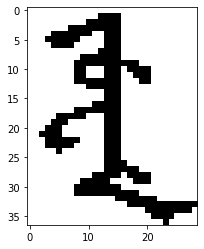

Number of letters in word 1 = 4


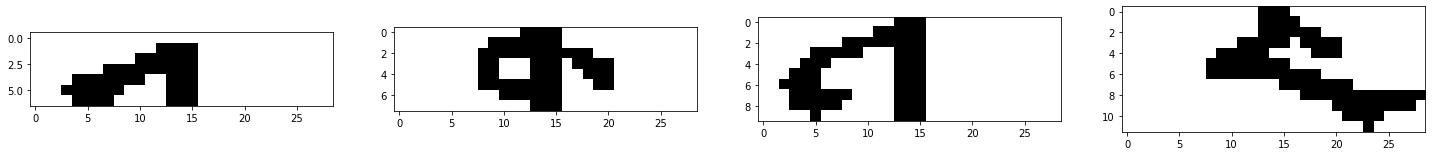

In [353]:
# Pre-process and Visualize the first word
plt.imshow(words[0][0], cmap = plt.get_cmap('gray'))
plt.show()

# print(letters[0])
# print(type(words[0][0]))
print('Number of letters in word 1 =', (len(letters[0])))
# plt.imshow(letters[0][0], cmap = plt.get_cmap('gray'))

# Now, let's double-check and display the 15 words cut from the first line of the script
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (25, 10))
ax1.imshow(letters[0][0], cmap = plt.get_cmap('gray'))
ax2.imshow(letters[0][1], cmap = plt.get_cmap('gray'))
ax3.imshow(letters[0][2], cmap = plt.get_cmap('gray'))
ax4.imshow(letters[0][3], cmap = plt.get_cmap('gray'))

plt.show()

### Visualize a long word (or two) cut into letters

Let's visualize some longer words. How about words #4, 7, and 10 from line 1? 

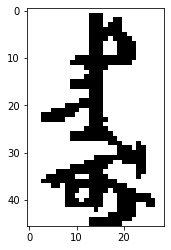

Number of letters in word 4 = 5


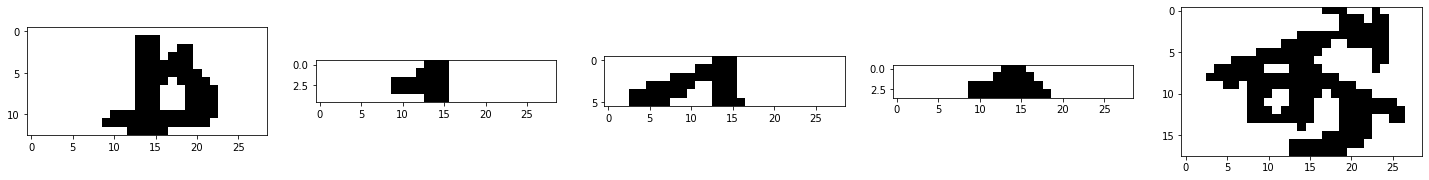

In [355]:
# Word 4
plt.imshow(words[0][3], cmap = plt.get_cmap('gray'))
plt.show()

print('Number of letters in word 4 =', (len(letters[3])))

# Now, let's double-check and display the 15 words cut from the first line of the script
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 10))
ax1.imshow(letters[3][0], cmap = plt.get_cmap('gray'))
ax2.imshow(letters[3][1], cmap = plt.get_cmap('gray'))
ax3.imshow(letters[3][2], cmap = plt.get_cmap('gray'))
ax4.imshow(letters[3][3], cmap = plt.get_cmap('gray'))
ax5.imshow(letters[3][4], cmap = plt.get_cmap('gray'))

plt.show()

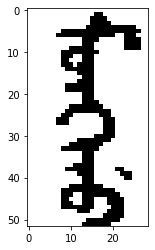

Number of letters in word 7 = 6


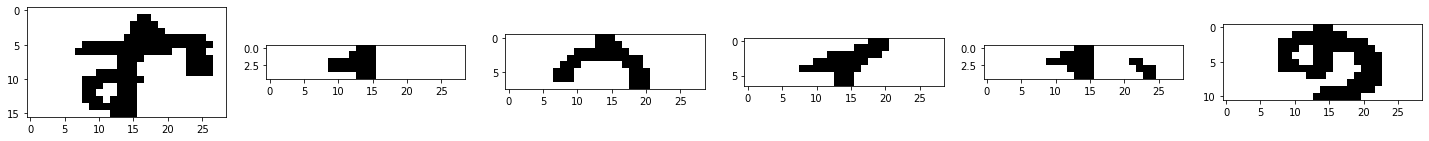

In [357]:
# Word 7
plt.imshow(words[0][6], cmap = plt.get_cmap('gray'))
plt.show()

print('Number of letters in word 7 =', (len(letters[6])))

# Now, let's double-check and display the 15 words cut from the first line of the script
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (25, 10))
ax1.imshow(letters[6][0], cmap = plt.get_cmap('gray'))
ax2.imshow(letters[6][1], cmap = plt.get_cmap('gray'))
ax3.imshow(letters[6][2], cmap = plt.get_cmap('gray'))
ax4.imshow(letters[6][3], cmap = plt.get_cmap('gray'))
ax5.imshow(letters[6][4], cmap = plt.get_cmap('gray'))
ax6.imshow(letters[6][5], cmap = plt.get_cmap('gray'))

plt.show()

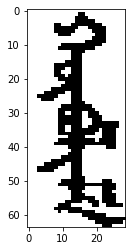

Number of letters in word 10 = 6


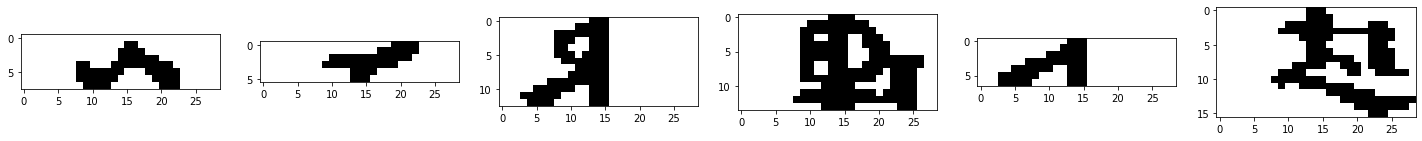

In [359]:
# Word 10
plt.imshow(words[0][9], cmap = plt.get_cmap('gray'))
plt.show()

print('Number of letters in word 10 =', (len(letters[9])))

# Now, let's double-check and display the 15 words cut from the first line of the script
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (25, 10))
ax1.imshow(letters[9][0], cmap = plt.get_cmap('gray'))
ax2.imshow(letters[9][1], cmap = plt.get_cmap('gray'))
ax3.imshow(letters[9][2], cmap = plt.get_cmap('gray'))
ax4.imshow(letters[9][3], cmap = plt.get_cmap('gray'))
ax5.imshow(letters[9][4], cmap = plt.get_cmap('gray'))
ax6.imshow(letters[9][5], cmap = plt.get_cmap('gray'))

plt.show()